In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
import statistics as st
import anndata as ad
from src.functions import *
%matplotlib inline

In [2]:
dataset_co_cult = np.load('data/Mx_Co_Cultured/marks_flitered_fluo.npy', allow_pickle = True)

dict_headers = ["norm_MM",
    "cell_marks",
    "nucl_fluo",
    "cell_fluo",
    "marks_fluo",
    "marks_cell_overlap",
    "mark_area",
    "overlap_indices",
    "marks_fluo_overlap",
    "cell_area",
    "marks_cell_overlap_indexes",
    "marks_cellLabels",
    "marks_samplingArea",
    "pmi",
    "overLaps"]

cell_area = dataset_co_cult[9]

# reference, which cells are covered by which marks
cell_marks = dataset_co_cult[1]

# size of every mark
mark_area = dataset_co_cult[6]

# reference of overlap area between cells and marks
marks_cell_overlap = dataset_co_cult[5]



In [3]:
if(False):
    selected_cells = ['3', '100', '21', '43', '547']
    cell_marks = {k:v for k,v in cell_marks.items() if k in selected_cells}
    marks_cell_overlap = {k:v for k,v in marks_cell_overlap.items() if k in selected_cells}
    selected_pixels = ['2']
    for _, cell in cell_marks.items():
        selected_pixels = selected_pixels + [str(n) for n in cell]

    selected_pixels.sort(key = int)
    mark_area = {k:v for k,v in mark_area.items() if k in selected_pixels}

    selected_pixels

In [4]:
# calculating different cell x pixel matrices
overlap_matrix, sampling_prop_matrix, sampling_spec_matrix = get_matrices(mark_area=mark_area, marks_cell_associations=cell_marks, marks_cell_overlap=marks_cell_overlap)
sampling_spec_matrix

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_2490,pixel_2491,pixel_2492,pixel_2493,pixel_2494,pixel_2495,pixel_2496,pixel_2497,pixel_2498,pixel_2499
cell_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:

ion_intensities = pd.read_csv('data/Mx_Co_Cultured/sm_annotation_detections.csv')

# ion_intensities = ion_intensities[['C16H30O2', "C25H44NO7P", "C45H78NO8P"]]
# ion_intensities = ion_intensities.iloc[selected_pixels]

ion_intensities = ion_intensities.drop(['Num', 'X', 'Y', 'Z', 'R'], axis=1)
# ion_intensities = ion_intensities.iloc[:, 0:10]
ion_intensities.index = [PIXEL_PRE + str(i) for i in ion_intensities.index]
ion_intensities

,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
pixel_0,11732.452,996.42834,0.000000,96.63648,251.41237,1035.7161,508.46760,776.2968,728.43120,1268.3046,...,263.37576,252.51741,0.0,244.01695,0.00000,99.36901,0.0,2732.2040,1450.11540,128.282870
pixel_1,8926.941,644.85220,98.860180,94.53568,129.45300,1127.7477,660.01980,798.9810,499.13810,1126.1990,...,269.30545,126.23382,0.0,491.70282,340.28522,75.63770,0.0,4471.3240,1770.75710,400.891660
pixel_2,16184.508,1443.74080,122.435680,459.26910,298.34604,874.1114,869.47440,1570.6218,1599.04420,1897.0496,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,970.5054,616.07654,78.222760
pixel_3,17386.785,1770.08830,0.000000,521.62244,392.64360,1581.3160,851.89560,1496.8848,1700.58310,2238.6267,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,1037.3005,702.37850,0.000000
pixel_4,17993.777,2441.13100,0.000000,424.59857,589.03710,1536.0576,1004.76526,1373.1233,1684.19860,2142.4817,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,1332.7043,940.42100,120.620830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pixel_2495,14193.198,1098.00960,377.735440,133.33331,0.00000,1268.6356,966.20984,1225.4326,1056.80550,2004.0934,...,130.08005,229.90854,0.0,136.83795,0.00000,0.00000,0.0,4241.5864,1591.95830,317.245880
pixel_2496,17826.373,2204.89750,124.410450,604.37280,635.19990,1172.6652,2027.87210,2225.9185,2475.11870,3223.1426,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,2617.0530,1362.17570,85.987526
pixel_2497,20524.766,2208.07860,131.849640,535.55316,437.42600,1162.7046,1485.94580,1914.0786,1891.50900,3095.1462,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,3441.5498,2130.13530,101.250000
pixel_2498,13827.365,1398.90610,117.092980,228.95663,93.65218,922.5511,1030.80410,1423.4183,1002.28130,2138.9333,...,184.42477,230.75467,0.0,108.41697,0.00000,368.53442,0.0,5551.5240,2327.51880,254.901870


In [7]:
# sampling_prop_threshold = 0.3
# sampling_spec_threshold = 0
# 
# pixel_sampling_prop_keep = sampling_prop_matrix.sum(axis = 0) > sampling_prop_threshold
# pixel_sampling_spec_keep = sampling_spec_matrix > sampling_spec_threshold
# 
# sampling_prop_matrix_filtered = sampling_prop_matrix.multiply(pixel_sampling_prop_keep, axis=1)
# sampling_spec_matrix_filtered = sampling_spec_matrix * pixel_sampling_spec_keep
# 
# sampling_prop_matrix_filtered
# 
# norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensities.columns)
# 
# for ion, intensities in ion_intensities.items():
#     inverted_prop_matrix = sampling_prop_matrix_filtered / (sampling_prop_matrix_filtered ** 2)
#     # first, we divide pixel intensities by their respective cell overlaps. That way we get theoretical intensities for a complete pixel-cell overlap
#     norm_spots = inverted_prop_matrix.multiply(intensities, axis=1) 
#     # next we multiply these theoretical intensities with their relative contribution to the total cell-pixels-overlap area
#     weighted_spots = norm_spots * sampling_spec_matrix_filtered
#     # the sum of the individual weighted intensities corresponds to the cell-specific intensity.
#     # finally, these cell-specific intensities are divided by the sum of weights. This important for the situation where weights do not sum up to 1 (filtering)
#     norm_ion_intensities[ion] = norm_spots.sum(axis=1) / sampling_spec_matrix_filtered.sum(axis=1)
# 
# norm_ion_intensities

In [8]:
def cell_normalization_Rappez(sampling_prop_matrix, sampling_spec_matrix, ion_intensity_matrix, n_jobs = 10, sampling_prop_threshold = 0.3, sampling_spec_threshold = 0):
    
    
    # filter out pixels with little overlap with any cell (thus sum of all overlaps)
    pixel_sampling_prop_keep = sampling_prop_matrix.sum(axis = 0) > sampling_prop_threshold
    # filter out pixels with low contributions to a cell
    pixel_sampling_spec_keep = sampling_spec_matrix > sampling_spec_threshold

    sampling_prop_matrix_filtered = sampling_prop_matrix.multiply(pixel_sampling_prop_keep, axis=1)
    sampling_spec_matrix_filtered = sampling_spec_matrix * pixel_sampling_spec_keep

    # create dataframe for results
    norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensity_matrix.columns)
    inverted_prop_matrix = sampling_prop_matrix_filtered / (sampling_prop_matrix_filtered ** 2)

    def process_ion_column(ion_intensity_series, ion):
        # first, we divide pixel intensities by their respective cell overlaps. That way we get theoretical intensities for a complete pixel-cell overlap
        norm_spots = inverted_prop_matrix.multiply(ion_intensity_series, axis=1) 
        # next we multiply these theoretical intensities with their relative contribution to the total cell-pixels-overlap area
        weighted_spots = norm_spots * sampling_spec_matrix_filtered
        # the sum of the individual weighted intensities corresponds to the cell-specific intensity.
        # finally, these cell-specific intensities are divided by the sum of weights. This important for the situation where weights do not sum up to 1 (filtering)
        deconvol_series = norm_spots.sum(axis=1) / sampling_spec_matrix_filtered.sum(axis=1)

        deconvol_series.name = ion
        return(deconvol_series)

    devoncol_df = Parallel(n_jobs=n_jobs)(delayed(process_ion_column)(ion_intensity_series=column, ion=ion) for ion, column in tqdm(ion_intensity_matrix.items()))
  
    return(pd.concat(devoncol_df, axis=1))


norm_ion_intensities = cell_normalization_Rappez(sampling_prop_matrix=sampling_prop_matrix, sampling_spec_matrix=sampling_spec_matrix, ion_intensity_matrix=ion_intensities, n_jobs=10)

norm_ion_intensities.dropna()

60it [01:05,  1.26s/it]

In [ ]:
# def cell_normalization_Rappez(sampling_prop_matrix, sampling_spec_matrix, ion_intensity_matrix, sampling_prop_threshold = 0.3, sampling_spec_threshold = 0):
#     
#     # filter out pixels with little overlap with any cell (thus sum of all overlaps)
#     pixel_sampling_prop_keep = sampling_prop_matrix.sum(axis = 0) > sampling_prop_threshold
#     # filter out pixels with low contributions to a cell
#     pixel_sampling_spec_keep = sampling_spec_matrix > sampling_spec_threshold
# 
#     sampling_prop_matrix_filtered = sampling_prop_matrix.multiply(pixel_sampling_prop_keep, axis=1)
#     sampling_spec_matrix_filtered = sampling_spec_matrix * pixel_sampling_spec_keep
# 
#     # create dataframe for results
#     norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensity_matrix.columns)
#     inverted_prop_matrix = sampling_prop_matrix_filtered / (sampling_prop_matrix_filtered ** 2)
# 
#     for ion, intensities in ion_intensity_matrix.items():
#         # first, we divide pixel intensities by their respective cell overlaps. That way we get theoretical intensities for a complete pixel-cell overlap
#         norm_spots = inverted_prop_matrix.multiply(intensities, axis=1) 
#         # next we multiply these theoretical intensities with their relative contribution to the total cell-pixels-overlap area
#         weighted_spots = norm_spots * sampling_spec_matrix_filtered
#         # the sum of the individual weighted intensities corresponds to the cell-specific intensity.
#         # finally, these cell-specific intensities are divided by the sum of weights. This important for the situation where weights do not sum up to 1 (filtering)
#         norm_ion_intensities[ion] = norm_spots.sum(axis=1) / sampling_spec_matrix_filtered.sum(axis=1)
# 
#     
#     return(norm_ion_intensities)
# 
# 
# norm_ion_intensities = cell_normalization_Rappez(sampling_prop_matrix=sampling_prop_matrix, sampling_spec_matrix=sampling_spec_matrix, ion_intensity_matrix=ion_intensities)
# 
# norm_ion_intensities

In [ ]:
# this is how martijn performed the calculations

# norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensities.columns)
# for ion, intensities in ion_intensities.items():
#     sum_prop_matrix = sampling_prop_matrix_filtered.sum(axis=0).replace(to_replace=0, value=pd.NA)
#     
#     norm_spots = intensities / sum_prop_matrix
#     sums = sampling_spec_matrix_filtered.multiply(norm_spots, axis=1)
#     norm_ion_intensities[ion] = sums.sum(axis=1) / sampling_spec_matrix_filtered.sum(axis=1)
#     
# norm_ion_intensities

In [ ]:
full_pixels_matrix = sampling_prop_matrix.apply(lambda x: x == 1).sum(axis=0)
full_pixels = full_pixels_matrix[full_pixels_matrix == 1].index

full_pixel_intensities = ion_intensities.apply(lambda x: st.mean(x[full_pixels]))

full_pixel_intensities

C16H30O2      239.39496
C25H44NO7P     83.94426
C45H78NO8P      0.00000
dtype: float64

In [ ]:
total_pixel_overlap = sampling_prop_matrix.sum(axis=0).infer_objects()
total_pixel_overlap.name = 'sampling_proportion'
total_pixel_overlap

pixel_1      0.013177
pixel_2      0.000000
pixel_5      0.302913
pixel_6      0.302913
pixel_27     0.682927
pixel_28     1.000000
pixel_29     0.194139
pixel_78     0.043373
pixel_79     0.389432
pixel_657    0.817133
Name: sampling_proportion, dtype: float64

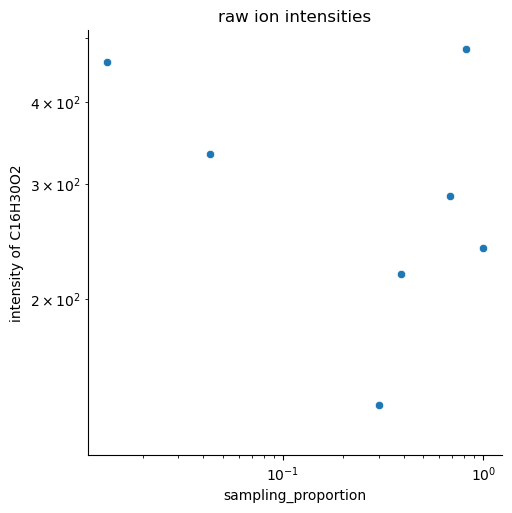

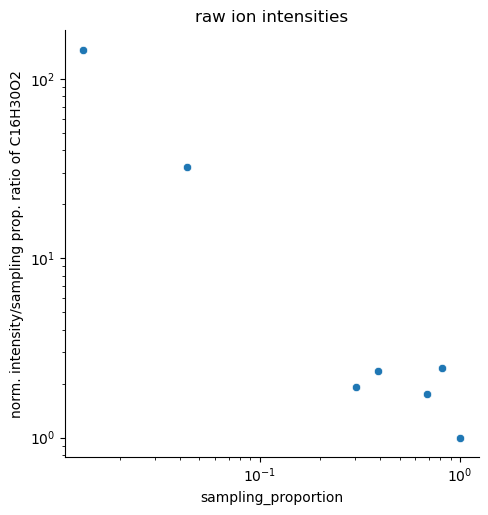

In [ ]:

def normalize_proportion_ratios(raw_df, proportion_series = total_pixel_overlap, normalized = True, full_pixel_intensities = full_pixel_intensities):

    if(len(raw_df) != len(proportion_series) or len(raw_df.columns) != len(full_pixel_intensities)):
        print('normalize_proportion_ratios: Inconsistant size of arguments.')

    intensity_prop_ratios = raw_df.divide(proportion_series.replace(to_replace=0, value=np.nan), axis = 0)
    norm_intensity_prop_ratios = intensity_prop_ratios.divide(full_pixel_intensities, axis=1)
    


    if(normalized): return(norm_intensity_prop_ratios)
    else: return(intensity_prop_ratios)

def log_log_regression_plot(df, molecule = '', x_axis= total_pixel_overlap, x_axis_name='sampling_proportion', title = 'Regression plot'):
    intensities_df = df.copy()

    norm_intensity_prop_ratios_df = normalize_proportion_ratios(intensities_df, proportion_series=x_axis)
    intensities_df[x_axis_name] = total_pixel_overlap
    norm_intensity_prop_ratios_df[x_axis_name] = total_pixel_overlap

    if not molecule in intensities_df.columns:
        molecule = intensities_df.columns[0]

    def render_plot(df, measure):

        plot = sns.relplot(data=df.dropna(subset = [molecule, x_axis_name]).infer_objects(), x=x_axis_name, y=molecule)
        plot.set(xscale="log")
        plot.set(yscale="log")
        plot.set(ylabel= measure + " of " + molecule)
        plot.set(title=title)

    render_plot(intensities_df, measure = 'intensity')
    render_plot(norm_intensity_prop_ratios_df, measure = 'norm. intensity/sampling prop. ratio')


log_log_regression_plot(ion_intensities, title = 'raw ion intensities')

In [ ]:
normalize_proportion_ratios(ion_intensities, proportion_series=total_pixel_overlap)

,C16H30O2,C25H44NO7P,C45H78NO8P
pixel_1,145.510187,544.964276,inf
pixel_2,NaN,NaN,NaN
pixel_5,0.000000,10.979656,NaN
pixel_6,1.902554,5.362184,NaN
pixel_27,1.757842,0.000000,NaN
pixel_28,1.000000,1.000000,NaN
pixel_29,0.000000,4.387874,NaN
pixel_78,32.113685,70.689624,inf
pixel_79,2.346074,0.000000,NaN
pixel_657,2.455531,5.708291,inf


In [ ]:
def quantreg(intensities_df, sampling_proportion_series, proportion_threshold = 0.1):
    
    reference = 'sampling_proportion'

    if len(intensities_df) != len(sampling_proportion_series):
        print('Quantreg: Inconsistent sizes of arguments')

    prop_ratio_df = normalize_proportion_ratios(raw_df=intensities_df, proportion_series=sampling_proportion_series)
    log_prop_series = np.log10(sampling_proportion_series)
    log_ratio_df = np.log10(prop_ratio_df.replace(np.nan, 0).infer_objects())
    log_ratio_df = log_ratio_df.replace([np.inf, - np.inf], np.nan)

    correction_factors = log_ratio_df.copy().applymap(lambda x: np.nan)
    params = {}
    predictions = log_ratio_df.copy().applymap(lambda x: np.nan)

    for ion in log_ratio_df.columns:
        df = pd.concat([log_ratio_df[ion], log_prop_series], axis=1)
        df_for_model = df[df.sampling_proportion > np.log10(proportion_threshold)].dropna()

        if len(df_for_model) < 3: print('skipping ' + ion); continue
        model = smf.quantreg(ion + ' ~ ' + reference, df_for_model)
        qrmodel = model.fit(q=0.5)
        params[ion] = qrmodel.params
        reg_correction = 10 ** qrmodel.predict(df)
        predictions[ion] = intensities_df[ion] / reg_correction
        correction_factors[ion] = reg_correction
    
    # print(pd.concat([ion_intensities['C16H30O2'], sampling_proportion_series, log_ratio_df['C16H30O2'], correction_factors['C16H30O2'], predictions['C16H30O2']], axis=1))

    return((correction_factors, pd.Series(params), predictions))


correction_factors, slopes, corrected_intensities = quantreg(ion_intensities, sampling_proportion_series=total_pixel_overlap)



skipping C45H78NO8P


/Users/mariusklein/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mariusklein/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


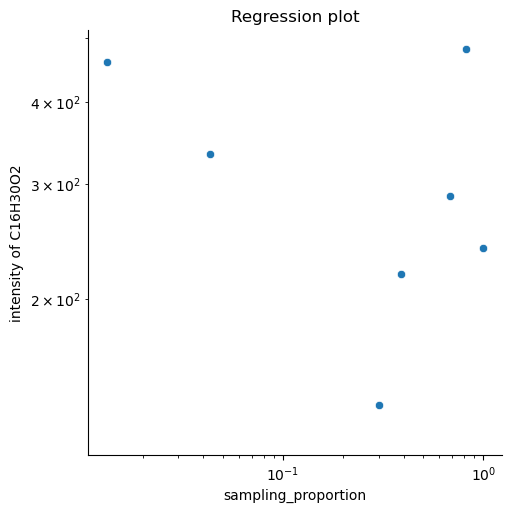

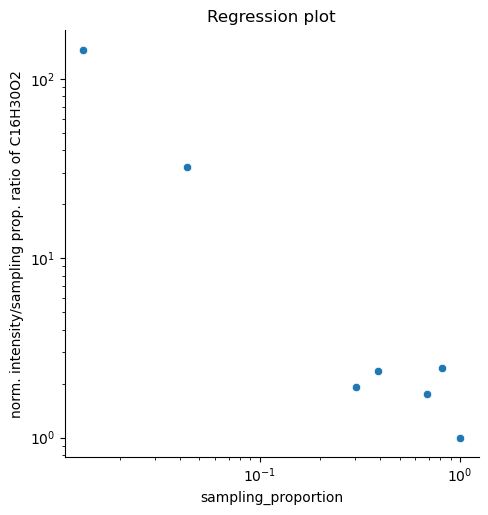

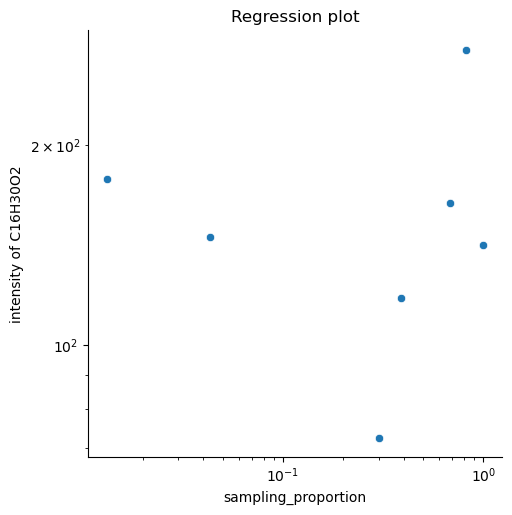

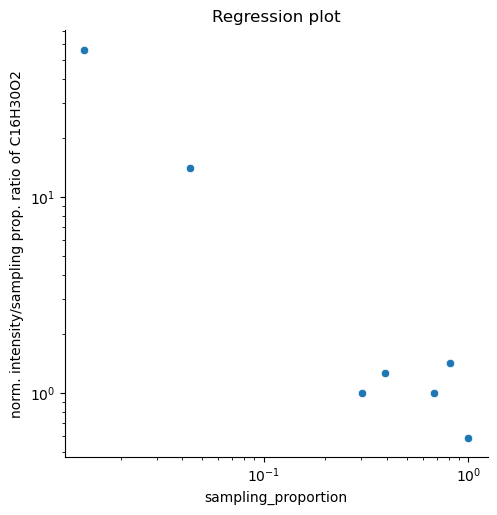

In [ ]:
plot_intensities = ion_intensities.copy()
log_log_regression_plot(ion_intensities, molecule='C16H30O2')
log_log_regression_plot(corrected_intensities, molecule='C16H30O2')

In [ ]:
norm_corr_ion_intensities = cell_normalization_Rappez(sampling_prop_matrix=sampling_prop_matrix, sampling_spec_matrix=sampling_spec_matrix, ion_intensity_matrix=corrected_ion_intensities, n_jobs=10)
#norm_corr_ion_intensities.dropna()

104it [00:03, 33.19it/s]


In [ ]:
norm_corr_ion_intensities

,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
cell_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000
cell_43,19301.494008,1876.839859,292.215767,252.752539,386.326639,1816.532667,1671.259098,1719.570296,1445.288878,2584.844964,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,4059.660666,2039.276511,0.000000
cell_100,15397.200645,1619.563420,187.466504,488.813787,595.085029,1071.565206,1376.805238,1420.820042,1448.590116,1979.764838,...,209.938824,169.849437,0.000000,0.000000,0.00000,0.0,0.0,6361.836886,1864.399838,628.918123
cell_547,47409.947298,4613.988998,1419.448243,926.427844,992.032887,5264.729569,4257.616550,4972.861218,5205.413758,7291.455237,...,0.000000,0.000000,34.452061,265.383055,88.27009,0.0,0.0,14096.488392,5361.071657,1041.372700


HeLa      715
NIH3T3    492
Name: celltype, dtype: int64


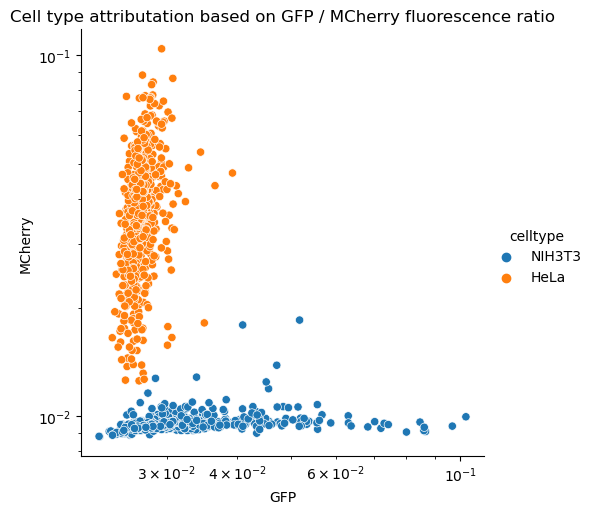

In [ ]:
condition_metadata = pd.read_csv('data/Mx_Co_Cultured/MORPHnMOL.csv')
condition_metadata['GFP'] = condition_metadata.Intensity_MeanIntensity_GFP_quantif
condition_metadata['MCherry'] = condition_metadata.Intensity_MeanIntensity_mCherry_quantif
condition_metadata['fluorescence_ratio'] = np.log(condition_metadata.GFP / condition_metadata.MCherry)

#condition_metadata['celltype'] = 'HeLa' if condition_metadata.fluorescence_ratio < 0.8 else 'NIH3T3'
condition_metadata['celltype'] = np.where(condition_metadata.fluorescence_ratio < 0.8, 'HeLa', 'NIH3T3')

print(condition_metadata['celltype'].value_counts())

plot = sns.relplot(data=condition_metadata, x='GFP', y='MCherry', hue='celltype')
plot.set(xscale='log')
plot.set(yscale='log')
plot.set(title='Cell type attributation based on GFP / MCherry fluorescence ratio')



In [ ]:
condition_metadata = condition_metadata[['ObjectNumber', 'celltype', 'GFP', 'MCherry', 'fluorescence_ratio']]
condition_metadata.index = [CELL_PRE + str(i) for i in condition_metadata.ObjectNumber]
# condition_metadata.index = condition_metadata.index.map(str)
# norm_ion_intensities.index = norm_ion_intensities.index.map(str)

condition_metadata.index

Index(['cell_11', 'cell_13', 'cell_14', 'cell_15', 'cell_16', 'cell_17',
       'cell_19', 'cell_20', 'cell_21', 'cell_22',
       ...
       'cell_1482', 'cell_1487', 'cell_1489', 'cell_1491', 'cell_1494',
       'cell_1500', 'cell_1503', 'cell_1510', 'cell_1512', 'cell_1528'],
      dtype='object', length=1207)

In [ ]:
included_cells = norm_ion_intensities.index.intersection(condition_metadata.index)
adata = ad.AnnData(X=norm_ion_intensities.loc[included_cells], obs=condition_metadata.loc[included_cells])


/var/folders/4f/_xbd4zzj0qn7vf5j_y8v3v_m0000gn/T/ipykernel_82251/2632045253.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=norm_ion_intensities.loc[included_cells], obs=condition_metadata.loc[included_cells])


In [ ]:
print(adata)

sc.pp.filter_cells(adata, min_genes=1)

print(adata)

AnnData object with n_obs × n_vars = 4 × 3
    obs: 'ObjectNumber', 'celltype', 'GFP', 'MCherry', 'fluorescence_ratio'
AnnData object with n_obs × n_vars = 3 × 3
    obs: 'ObjectNumber', 'celltype', 'GFP', 'MCherry', 'fluorescence_ratio', 'n_genes'


IndexError: index 2 is out of bounds for axis 1 with size 2

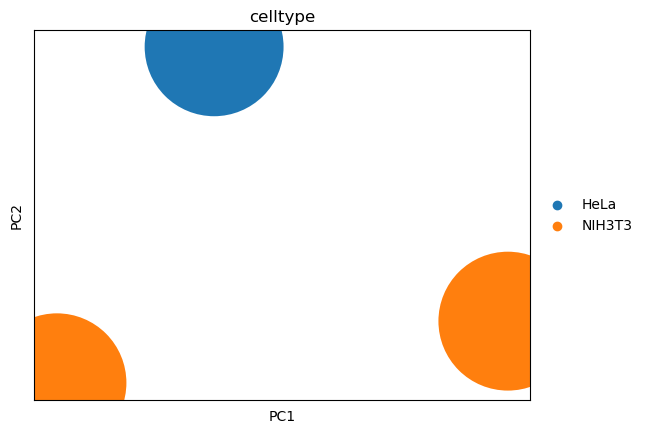

In [ ]:
sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pl.pca_overview(adata, color='celltype')

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=1, n_components=2)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
